In [ ]:
# ===========================
# Investigated the homogeneous binary nucleation of atmospherically-relevant molecules
# =========================== 

# 📊 Generate Plot: 
#    Plot fragmentation of unary component of clusters 
# ---------------------------
# Table of Contents
# 1️⃣ Fragmentation of unary component of clusters
# ----------------------------

In [1]:
# ===============================
# 1️⃣ Fragmentation of unary component of clusters
# ===============================
# 📆 Date created: October 12, 2024 
# 📆 Date updated: October 13, 2024 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
import os
from matplotlib.legend_handler import HandlerTuple
from matplotlib.lines import Line2D

class HandlerLineScatterOverlay(HandlerTuple):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        # Adjust line length using xdescent and width
        line_length_factor = 0.8  # Fraction of width to use for the line length
        line_start = xdescent + width * (1 - line_length_factor) / 2
        line_end = xdescent + width * (1 + line_length_factor) / 2

        # Create the line and scatter point centered overlay
        line = Line2D([line_start, line_end], 
                      [ydescent + height / 2] * 2,
                      color=orig_handle[0].get_color(), 
                      linewidth=orig_handle[0].get_linewidth())
        scatter = Line2D([xdescent + width / 2], 
                         [ydescent + height / 2], 
                         marker='o', 
                         markersize=10, 
                         color=orig_handle[1].get_edgecolor(), 
                         markerfacecolor=orig_handle[1].get_facecolor())
        return [line, scatter]


def process_data_with_both_datasets(mol1_name, mol2_name, fragmentation_file, x_setting, y_setting, cbar_setting, save_path, skip_interval=1):
    start_time = time.time()

    # Define expected column names
    column_names = ['time', 'size', 'frequency']

    # Load fragmentation data
    print("Loading fragmentation data...")
    try:
        df_frag = pd.read_csv(fragmentation_file)
        print(f"Fragmentation data loaded in {time.time() - start_time:.2f} seconds.")
        print("Original DataFrame Columns:", df_frag.columns.tolist())
        
        # Check if expected columns exist
        if all(col in df_frag.columns for col in column_names):
            print("DataFrame has the correct headers.")
        else:
            print("DataFrame does not have the expected headers. Assigning correct headers.")
            df_frag = pd.read_csv(fragmentation_file, header=None, names=column_names)
            print("Assigned headers:", df_frag.columns.tolist())
    except FileNotFoundError:
        print(f"Error: File {fragmentation_file} not found.")
        return
    except Exception as e:
        print(f"Error loading fragmentation data: {e}")
        return

    if not all(col in df_frag.columns for col in column_names):
        print(f"Error: DataFrame does not contain the required columns {column_names}.")
        return

    # Calculate the largest cluster (total unary component) at each time frame
    print("Calculating largest cluster size (total unary component) per time frame...")
    try:
        df_frag['weighted_size'] = df_frag['size'] * df_frag['frequency']
        largest_clusters = df_frag.groupby('time')['weighted_size'].sum().reset_index()
        largest_clusters.columns = ['time', 'size']
        print("Largest cluster calculation successful.")
    except Exception as e:
        print(f"Error calculating largest cluster: {e}")
        return

    # Apply skip interval
    if skip_interval > 1:
        largest_clusters = largest_clusters.iloc[::skip_interval]

    # Pivot fragmentation data to wide format
    print("Pivoting fragmentation data to wide format...")
    try:
        df_frag_wide = df_frag.pivot(index='time', columns='size', values='frequency').fillna(0)
        df_frag_wide = df_frag_wide.reindex(sorted(df_frag_wide.columns, key=lambda x: float(x)), axis=1)
        print("Pivot successful.")
    except Exception as e:
        print(f"Error pivoting fragmentation data: {e}")
        return

    # Prepare fragmentation contributions
    print("Calculating fragmentation contributions...")
    try:
        df_frag_wide.columns = df_frag_wide.columns.astype(float)
        fragmentation_time = df_frag_wide.index
        fragmentation_contributions = df_frag_wide.columns.astype(float) * df_frag_wide
        if skip_interval > 1:
            fragmentation_contributions = fragmentation_contributions.iloc[::skip_interval]
            fragmentation_time = fragmentation_contributions.index
    except Exception as e:
        print(f"Error calculating fragmentation contributions: {e}")
        return

    # Plotting
    print("Creating stacked bar plot...")
    fig, ax = plt.subplots(figsize=(12, 8))
    cmap = plt.get_cmap('coolwarm')
    norm = plt.Normalize(vmin=0, vmax=1)

    total_values = fragmentation_contributions.sum(axis=1)
    bottom = np.zeros(len(fragmentation_contributions))

    for idx, (frag_size, frag_counts) in tqdm(enumerate(fragmentation_contributions.items()), total=len(fragmentation_contributions.columns), desc="Fragment Sizes"):
        ratios = frag_counts / total_values
        bar_colors = cmap(norm(ratios))
        ax.bar(
            fragmentation_time,
            frag_counts,
            bottom=bottom,
            color=bar_colors,
            edgecolor='black',
            width=0.9,
            zorder=1
        )
        bottom += frag_counts

    # Add color bar
    print("Adding color bar...")
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label(cbar_setting['label'], fontsize=cbar_setting['label_size'], labelpad=cbar_setting['label_pad'])
    cbar.ax.tick_params(labelsize=cbar_setting['tick_size'])
    if 'ticks' in cbar_setting:
        cbar.set_ticks(cbar_setting['ticks'])

    # Plot unary component (scatter point overlaying a line)
    print("Plotting total unary component (line and scatter point)...")
    line, = ax.plot(
        largest_clusters['time'],
        largest_clusters['size'],
        color='black',
        alpha=0.8,
        zorder=0,
        linewidth=1.5
    )
    scatter = ax.scatter(
        x=largest_clusters['time'],
        y=largest_clusters['size'],
        c='gray',
        s=100,
        alpha=1,
        edgecolor='black',
        zorder=2
    )

    # Customize axes
    print("Customizing axes...")
    if 'lim' in y_setting:
        y_min, y_max = y_setting['lim']
        ax.set_ylim(y_min, y_max)  # Explicitly set y-axis limits
    if 'ticks' in y_setting:
        ax.set_yticks(y_setting['ticks'])  # Explicitly set y-axis ticks
    ax.set_xlabel(x_setting['label'], fontsize=x_setting['label_size'], labelpad=x_setting['label_pad'])
    ax.set_xticks(x_setting['ticks'])
    ax.set_ylabel(y_setting['label'], fontsize=y_setting['label_size'], labelpad=y_setting['label_pad'])
    ax.tick_params(axis='x', labelsize=x_setting['tick_size'])
    ax.tick_params(axis='y', labelsize=y_setting['tick_size'])

    # Customize legend
    print("Customizing legend...")
    ax.legend(
        [(line, scatter)],  # Combine line and scatter as a single legend item
        ['total unary component'],  # Legend label
        fontsize=17,
        loc='upper left',
        bbox_to_anchor=(0.57, 1),
        handler_map={tuple: HandlerLineScatterOverlay()},  # Ensure combined symbol
    )

    plt.tight_layout()
    # Save the plot
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    plot_filename = f"combined_plot_{mol1_name}_{mol2_name}.png"
    plt.savefig(os.path.join(save_path, plot_filename), dpi=300)
    plt.show()
    plt.close()

Loading fragmentation data...
Fragmentation data loaded in 2.94 seconds.
Original DataFrame Columns: ['time', 'size', 'frequency']
DataFrame has the correct headers.
Calculating largest cluster size (total unary component) per time frame...
Largest cluster calculation successful.
Pivoting fragmentation data to wide format...
Pivot successful.
Calculating fragmentation contributions...
Creating stacked bar plot...


Fragment Sizes: 100%|██████████| 52/52 [00:01<00:00, 44.95it/s]


Adding color bar...
Plotting total unary component (line and scatter point)...
Customizing axes...
Customizing legend...


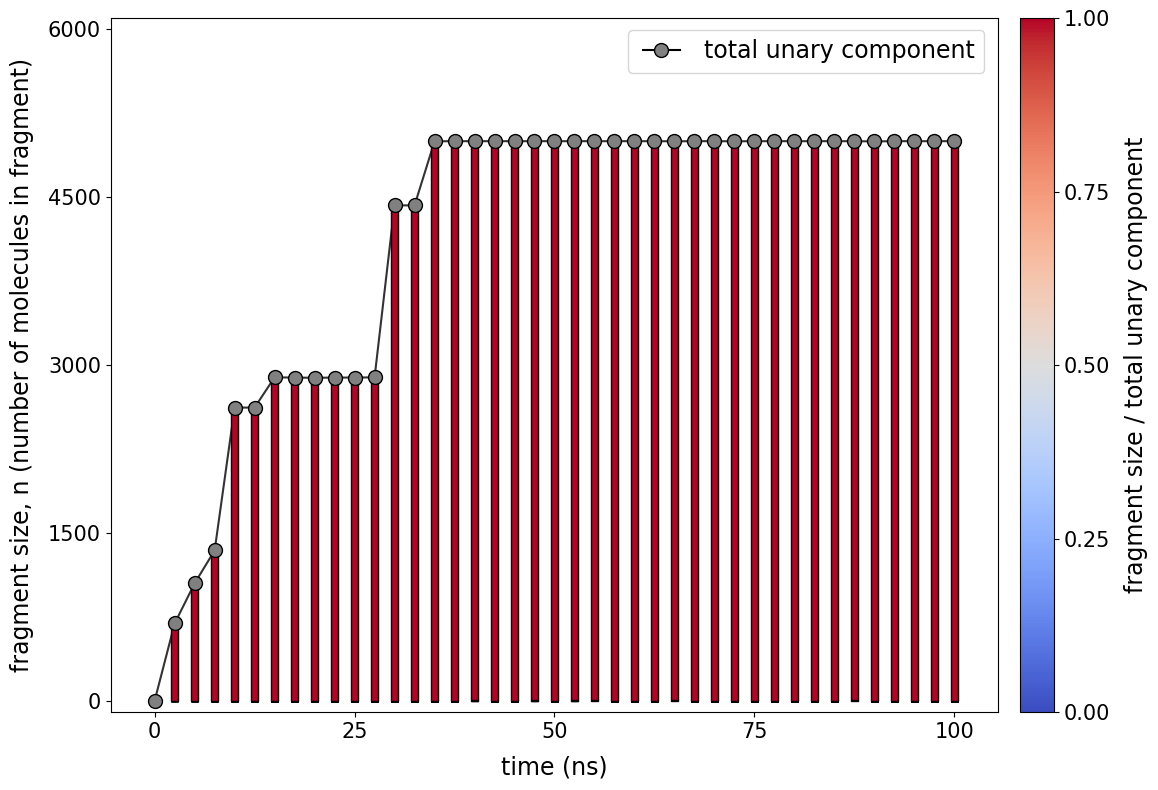

In [3]:
# ----------------------------
# Script Activation for mol1 fragmentation
# ----------------------------
if __name__ == "__main__":
    x_setting = {
        'label': 'time (ns)',
        'label_size': 17,
        'label_pad': 10,
        'ticks': [0, 25, 50, 75, 100],
        'tick_size': 15
    }
    y_setting = {
        'label': 'fragment size, n (number of molecules in fragment)',
        'label_size': 17,
        'label_pad': 10,
        'ticks': [0, 1500, 3000, 4500, 6000],
        'tick_size': 15,
        'lim': [-100, 6100]
    }
    cbar_setting = {
        'label': 'fragment size / total unary component',
        'label_size': 17,
        'label_pad': 10,
        'tick_size': 15,
        'ticks': [0, 0.25, 0.5, 0.75, 1.0]
    }
    mol1_name = "BUT"
    mol2_name = "MET"
    fragmentation_file = f"fragmentation_{mol1_name}_{mol2_name}_mol1.csv"
    #fragmentation_file = f"fragmentation_{mol1_name}_{mol2_name}_mol2.csv"
    save_path = './fig/'
    
    process_data_with_both_datasets(mol1_name, mol2_name, fragmentation_file, x_setting, y_setting, cbar_setting, save_path, skip_interval=5)

Loading fragmentation data...
Fragmentation data loaded in 0.04 seconds.
Original DataFrame Columns: ['time', 'size', 'frequency']
DataFrame has the correct headers.
Calculating largest cluster size (total unary component) per time frame...
Largest cluster calculation successful.
Pivoting fragmentation data to wide format...
Pivot successful.
Calculating fragmentation contributions...
Creating stacked bar plot...


Fragment Sizes: 100%|████████| 259/259 [00:05<00:00, 46.13it/s]


Adding color bar...
Plotting total unary component (line and scatter point)...
Customizing axes...
Customizing legend...


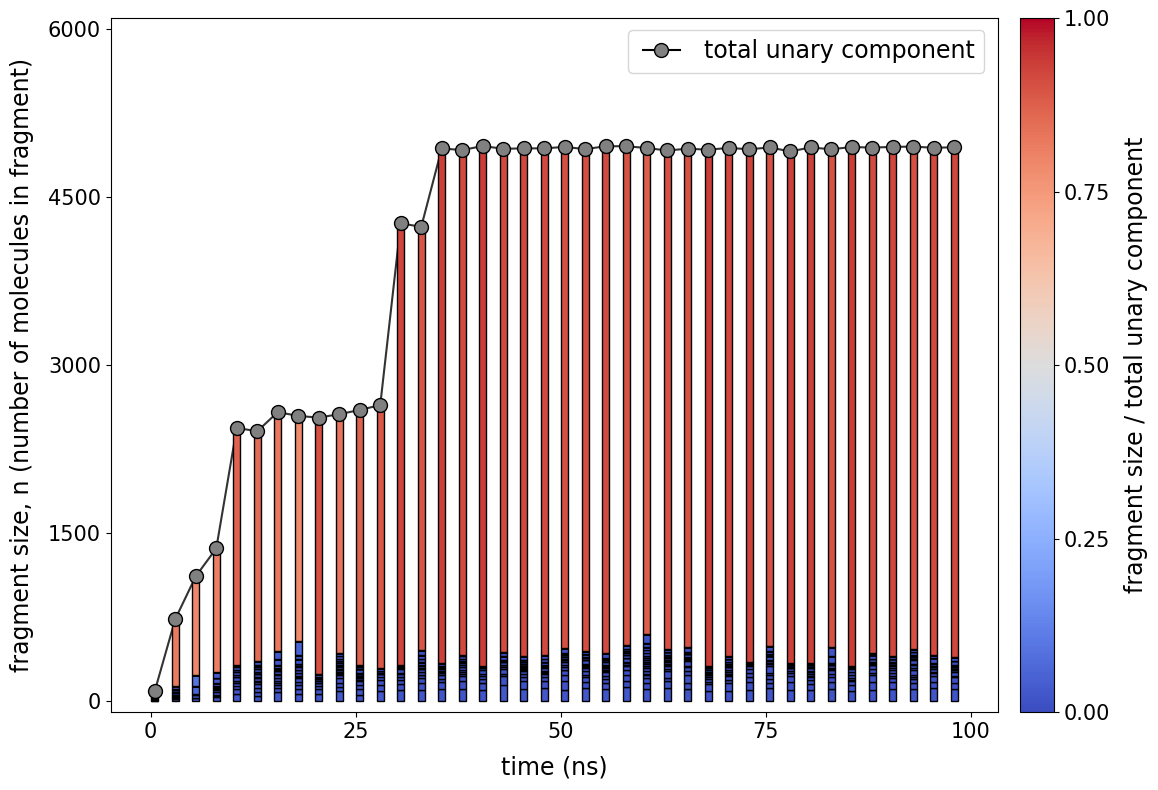

In [4]:
# ----------------------------
# Script Activation for mol2 fragmentation
# ----------------------------
if __name__ == "__main__":
    x_setting = {
        'label': 'time (ns)',
        'label_size': 17,
        'label_pad': 10,
        'ticks': [0, 25, 50, 75, 100],
        'tick_size': 15
    }
    y_setting = {
        'label': 'fragment size, n (number of molecules in fragment)',
        'label_size': 17,
        'label_pad': 10,
        'ticks': [0, 1500, 3000, 4500, 6000],
        'tick_size': 15,
        'lim': [-100, 6100]
    }
    cbar_setting = {
        'label': 'fragment size / total unary component',
        'label_size': 17,
        'label_pad': 10,
        'tick_size': 15,
        'ticks': [0, 0.25, 0.5, 0.75, 1.0]
    }
    mol1_name = "BUT"
    mol2_name = "MET"
    #fragmentation_file = f"fragmentation_{mol1_name}_{mol2_name}_mol1.csv"
    fragmentation_file = f"fragmentation_{mol1_name}_{mol2_name}_mol2.csv"
    save_path = './fig/'
    process_data_with_both_datasets(mol1_name, mol2_name, fragmentation_file, x_setting, y_setting, cbar_setting, save_path, skip_interval=5)